### Load simulator metadata

In [ ]:
import json
import xml.etree.ElementTree as ET
from pathlib import Path

input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'
simulation_setup = "lowCongestion_5minDemand"

config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])
# [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
#sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))
sim_setup = json.load(open(input_path + f"simulation_setups_{simulation_setup}.json"))


In [ ]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

In [ ]:
## Main simulator function
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import torch

from pandas import DataFrame
from pathlib import Path


def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_{sim_setup['prefix_sim_run']}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips



def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



def generate_od_xml(x, config, sim_setup):

    init_od_path = f"{config['NETWORK']}/{sim_setup['init_od']}"

    if Path(init_od_path).is_file():
        print("Reading:",init_od_path)
        tree = ET.parse(init_od_path)
        root = tree.getroot()

        for i,x in enumerate(x):
            root[0][i].attrib["count"] = str(int(np.round(x)))
            
    file_name = f"{config['NETWORK']}/{sim_setup['current_od']}"
    print('Saving: '+file_name)
    tree.write(file_name)
## Find upper and lower bounds
import pandas as pd

def transform_od_xml_to_pandas(file_path_xml):

    tree = ET.parse(file_path_xml)
    root = tree.getroot()

    od_mat = []
    for taz_elem in root.iter('tazRelation'):
        od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])
    
    df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

    return df_od

file_path_xml = str(config['NETWORK']) + "/" + sim_setup['gt_od']
df_gt = transform_od_xml_to_pandas(file_path_xml)

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = df_gt.shape[0]

bounds = torch.tensor([
    [ df_gt[ 'tazCount'].min() for _ in range(dim_od)],
    [ df_gt[ 'tazCount'].max() for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds


In [ ]:
### Obtain ground-truth value
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)


## High-Dimensional sample-efficient Bayesian Optimization 

Source: https://botorch.org/tutorials/saasbo

In [15]:
from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.models.transforms import Standardize
from botorch.utils.transforms import normalize


In [ ]:
WARMUP_STEPS = 32
NUM_SAMPLES = 16
THINNING = 16

## BayesOpt loop

In [17]:
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize


def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    
    dim = acq_func.model.train_inputs[0].size(dim=1)

    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

### Run loop

In [20]:
# Read initial data
df_0 = pd.read_csv(f"./{simulation_setup}_initial_data_bo.csv")

In [21]:
prefix_input = "current"
prefix_output = "current"
loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/{prefix_output}_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"


In [22]:

NITER = 100
BATCH_SIZE = 1 
NUM_RESTARTS = 10
RAW_SAMPLES = 1024
    
best_value = []

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

for i in range(NITER):

    print(f"########### BO iteration={i+1} ###########")

    # Obtain sampling locations x
    train_X = torch.from_numpy(
        df_training[[col for col in df_training.columns if "x" in col]].values
    )    

    # Normalize
    train_X_norm = normalize(train_X,bounds)

    # Obtain reponse data
    train_Y = -torch.from_numpy(df_training[["loss"]].values) # Take negative

    ###
    #Obtain next sampling location given current training data
    ###

    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=train_X_norm,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1),
    )

    # Fit model
    print("Fitting GP model...")
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    # Computing the median lengthscales over the MCMC dimensions 
    # makes it clear that the first feature has the smallest lengthscale
    print("Median lengthscales over the MCMC dimensions")
    print(gp.median_lengthscale.detach())    

    # Construct acquistion function 
    EI = qExpectedImprovement(model=gp, best_f=best_y)
    
    # Maximize acquisition function to get next observation
    print("Optimizing acquisition function...")
    x_i = optimize_acqf_and_get_observation(acq_func=EI,bounds=bounds)
    x_i = x_i.cpu().detach().numpy()

    print(f"Next {BATCH_SIZE} sampling locations:{x_i}.")

    # Sample simulator
    batch_data_i = []
    for j in range(BATCH_SIZE):
        loss = []
        print(f"########### Sampling location={j+1} ###########")

        # Generate OD
        print(f"Generating new OD...")
        generate_od_xml(x_i[j], config, sim_setup)

        # Query simulator
        print(f"Querying simulator...")
        run_sumo(config, sim_setup, prefix_input, prefix_output)

        # Compute metrics
        print(f"Computing metrics...")
        loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

        # Compute loss with respect to gt
        y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

        # Parse training data
        df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                            columns = [f"x_{i+1}" for i in range(dim_od)])
        df_j['loss'] = y_i
        batch_data_i.append(df_j)

    df_i = pd.concat(batch_data_i)
    df_i["bo_iteration"] = i+1

    df_training = pd.concat([df_training,df_i])



########### BO iteration=1 ###########
##### best_value=-0.7838804658632956 #####
Fitting GP model...
Median lengthscales over the MCMC dimensions
tensor([4.6789, 1.7905, 5.8472, 2.8266, 1.7582, 6.0688, 1.8174, 3.0640, 4.8807,
        2.9394, 2.6817, 2.3299, 2.2773, 3.8400, 3.2585, 1.3113, 6.2254, 2.9573,
        1.9141, 1.5382, 1.5254, 3.3531, 5.2383, 3.6048, 4.0625, 1.6892, 3.2964,
        2.0978, 2.3166, 4.5704, 3.4506, 1.0194, 1.3629, 1.0207, 5.1620, 3.7404,
        2.5140, 1.7475, 2.5022, 3.1737, 3.6104, 1.8796], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[3.         3.         1.         2.36780514 1.32480334 1.71064903
  1.         2.21944944 1.4334293  1.44851346 1.26988737 1.33919527
  1.         2.56242646 2.76666505 1.         1.90582119 2.787937
  2.17030277 3.         3.         2.20382336 1.         3.
  1.         2.46534423 1.15701352 1.3402971  1.29458804 2.30048041
  1.         2.36391765 2.12875829 1.70736118 1.26983422 2.33020

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([ 1.5023,  0.9848,  1.4213,  1.9448,  2.7153,  1.3149,  1.0212,  3.1096,
         4.3238,  4.1722, 12.7168,  2.4501,  1.6268,  1.1168,  3.1484,  0.3794,
         1.6304,  2.6345, 10.7532,  2.5388,  1.9405,  5.1504,  2.7801,  2.7137,
         5.0969,  2.9624,  1.6687,  3.1827,  1.8788,  2.2945,  4.0374,  2.4287,
         1.0500,  2.3176,  2.2377,  1.8192,  1.1152,  2.6394,  1.1639,  2.8860,
         3.7930,  3.4756], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.47356541 2.39719046 1.         1.98246369 2.71445065 2.21151554
  2.05389179 1.28339152 3.         2.08045035 1.88485367 2.66758235
  2.40639394 2.94555305 1.49937272 1.18039209 1.86579313 2.38514589
  2.86309141 3.         1.         1.84962696 2.68753048 2.29836586
  1.28746035 2.11910701 1.54549049 1.04177728 1.27634339 2.40928381
  1.         1.         2.96908903 2.94464543 2.36383733 3.
  1.67545814 1.         1.81107034 1.70981457 

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([1.9192, 1.4994, 0.3249, 0.9639, 2.5921, 1.7867, 0.8684, 1.1683, 1.0227,
        1.2648, 1.9909, 1.3311, 0.9289, 1.3545, 0.5756, 1.7335, 1.7372, 1.7643,
        1.4183, 2.2176, 1.9082, 1.5768, 1.1521, 1.1762, 1.2443, 0.8249, 1.2019,
        0.8231, 0.9806, 0.6172, 0.5130, 1.0924, 0.5711, 1.0696, 1.7515, 1.5246,
        1.2864, 0.5492, 1.0402, 0.8851, 0.9435, 0.9890], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.6555999  1.79943712 2.96064045 2.4428985  2.76554243 1.1067564
  1.20564567 1.85037994 2.74492261 2.65929408 2.77927717 1.21852811
  1.38070719 2.80610056 1.13298701 2.51363366 1.16859028 2.76946141
  1.30576117 1.30572421 1.74700203 2.77639026 1.25950151 2.72539555
  1.57273321 2.85981573 2.90542657 1.3525481  1.30479019 1.26911519
  1.51242051 2.88035951 2.74736159 2.02922424 2.99676762 1.86470095
  2.45371637 2.75278034 1.95653862 2.57372896 2.40843556 2.88440901]].
########### Sampli

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([1.3710, 1.2149, 1.7586, 2.0851, 1.9625, 1.3733, 1.2918, 2.2763, 1.5819,
        2.7254, 1.9344, 0.5687, 1.3895, 2.3268, 2.7113, 1.1726, 1.6654, 1.1680,
        0.8942, 1.0839, 2.8018, 1.7137, 2.7508, 1.6865, 1.1560, 1.7070, 1.3374,
        3.2792, 0.7849, 1.3458, 0.3297, 1.2308, 0.6552, 1.3141, 2.4227, 1.4652,
        1.0277, 0.7961, 1.4993, 2.1222, 0.8694, 1.6756], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.63935153 1.95884183 1.06973568 2.81588483 2.810566   1.44883366
  1.28231357 2.55788825 2.37540456 2.49459136 2.84719457 2.83618386
  1.62254585 2.85831807 1.68357724 2.91010255 2.11336215 1.95499079
  1.95854439 1.36814774 1.15661478 2.8083229  2.35779698 1.03786325
  2.26919639 1.09086193 1.095438   1.2816391  2.25799836 1.1258187
  1.20259145 1.25529082 1.6088155  1.80940825 2.59321979 1.30437286
  1.82384286 1.0960154  2.75148448 1.62429938 1.53037585 2.75857631]].
########### Sampli

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([ 3.2716,  2.2902,  2.3164,  3.8801,  2.1740,  2.6176,  3.0808,  3.8049,
         3.2076,  3.6733,  2.2042,  3.0062,  3.5472,  2.0031,  2.2353,  1.5783,
         1.6714,  1.7862,  3.1940,  3.7015,  2.7684,  3.9749,  4.6315,  5.3882,
         1.6983,  5.4111,  4.4023,  0.6060,  3.7652, 15.6608,  1.3112,  1.6110,
         1.2652,  3.0694,  2.9744,  4.6615,  1.8803,  0.4969,  1.9205,  2.1597,
         2.0849,  2.2295], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[2.44741533 1.73871509 2.19672127 1.53051931 2.15616688 1.01641558
  2.17597505 2.18275367 1.4134772  2.12674486 2.7459844  2.54345638
  1.6660875  1.4909069  1.21559424 1.530452   2.56265003 1.71992963
  2.37004444 1.13816633 1.79319284 1.96749746 2.0925279  2.24394985
  1.47539631 1.13996094 2.7039234  1.87926514 1.73803392 2.08898516
  2.56285946 1.10500886 2.9444364  2.45235808 1.38525847 2.55694944
  2.21912372 1.94047563 2.94524354 2.7

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([3.2606, 1.5524, 1.5675, 0.5389, 1.6057, 1.7045, 1.5948, 1.1666, 7.4878,
        4.3296, 4.9655, 0.9905, 4.3780, 0.4240, 0.6942, 2.0891, 3.8684, 2.4465,
        2.1262, 1.5749, 0.4510, 2.1931, 4.6986, 3.5917, 1.5471, 2.5695, 2.4735,
        2.2097, 2.2651, 1.2982, 1.6019, 1.4171, 2.2060, 2.4769, 1.4474, 0.9526,
        1.1566, 1.7789, 1.9451, 2.4894, 0.7592, 2.1992], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.         2.3905136  1.         1.80343738 2.52173541 1.28157309
  1.         1.76786889 3.         1.63803658 1.         2.09276904
  3.         3.         1.72658416 1.         1.         2.7498775
  2.57021665 3.         2.20953584 3.         1.56928811 3.
  1.59377675 1.27228477 1.68420461 1.         1.19704595 1.3923387
  1.22336881 1.         2.19760702 2.07080505 2.10574962 2.76528818
  1.         1.         1.         1.48223773 3.         2.19363397]].
########### Sampling locati

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([1.7595, 3.4979, 0.5830, 0.7378, 2.0268, 0.7196, 1.8288, 1.3790, 3.7677,
        0.7707, 0.4232, 1.9685, 1.3612, 0.9732, 1.8059, 2.3573, 1.7994, 0.8652,
        1.3514, 0.7289, 1.4125, 0.9829, 1.5639, 3.5499, 1.3977, 1.9079, 1.3487,
        1.6364, 1.6107, 1.5564, 0.9660, 2.2437, 0.6228, 1.5257, 0.6805, 2.9907,
        1.2794, 0.4567, 0.5707, 1.5183, 1.0808, 0.8302], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.56905714 2.63983333 1.         1.67727756 2.55720311 1.80211847
  1.48505975 2.46985629 2.95254866 2.04490144 2.05871855 1.66481064
  2.4824425  3.         1.50481004 1.         1.51817367 2.36487563
  1.96986898 2.85660665 2.38682726 3.         1.44992726 2.516051
  1.87516704 1.09081485 2.02287167 1.13921708 1.68849372 1.3337714
  1.24935713 2.21289549 2.34506967 1.37177772 2.15787684 2.02671454
  1.17116682 1.13950201 1.30905509 2.1447273  3.         1.83528694]].
########### Sampling

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

Median lengthscales over the MCMC dimensions
tensor([1.3347, 2.1812, 0.7678, 1.5408, 3.5126, 2.1696, 1.8063, 1.4722, 1.3471,
        1.6878, 1.7409, 1.7332, 1.9020, 2.0124, 1.8374, 1.0666, 1.7955, 1.8172,
        2.1534, 1.7061, 3.8184, 1.7182, 1.3916, 3.0778, 1.9178, 1.5355, 0.9962,
        2.3554, 1.9446, 2.8955, 1.6773, 0.4778, 1.8023, 2.3302, 1.5362, 2.9171,
        1.8088, 2.9094, 2.4877, 2.6255, 0.7887, 1.7707], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.75936138 2.38001999 1.58192181 1.29525707 1.18027839 2.96020347
  1.43914271 2.54451293 2.15092029 1.09857055 1.98054448 2.0300742
  2.55679433 2.54786931 1.68272435 1.73409821 1.29906941 1.0964661
  2.58127917 2.31771719 1.10673269 2.19914651 1.42471424 2.82200592
  1.16990945 2.17705677 2.87187096 2.39159025 1.81692834 2.69952157
  2.05605    2.74309157 2.83602915 1.1639526  2.88236153 2.79060754
  1.21847357 1.13158006 2.54681974 2.84622881 2.33890276 2.57591254]].
########### Samplin

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([ 2.7921,  2.8370,  4.0099,  4.9046,  7.8386, 13.3854,  5.3011, 14.2347,
         9.3771,  5.0374,  2.6693,  2.3032,  2.3911,  4.5984,  9.0665,  3.6011,
         3.5852, 13.3511,  3.1971,  2.7802,  6.7572,  2.1584,  7.2070,  3.9694,
         5.6087,  3.3585,  4.5374,  3.5670,  4.2388,  3.4709,  5.9972,  6.9006,
         6.6058,  3.8301,  8.7362,  3.6715,  1.3673,  2.9303,  5.0038,  2.8379,
        10.9649,  5.9276], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.53924838 2.8347753  1.83385455 1.93784478 1.84477539 2.08240358
  1.09949417 2.38842229 1.92719414 2.43974324 2.36561925 2.57116338
  2.10280411 1.32735445 2.2757692  2.08170723 2.43043564 2.36142084
  1.58782162 2.14444946 1.46809204 2.42204956 1.31988762 1.39056117
  2.95993672 2.04373472 2.17722568 2.19122523 1.36747256 2.2061206
  1.08052791 2.02433003 2.78156684 2.72496332 1.99593521 2.20234321
  2.56286575 2.06083462 2.80998871 2.72

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


Median lengthscales over the MCMC dimensions
tensor([0.7103, 0.5186, 0.2886, 1.2421, 0.3956, 0.5419, 0.5759, 0.6075, 0.5486,
        0.4063, 0.5878, 0.7839, 0.5495, 0.5942, 0.5449, 0.4669, 0.6309, 0.5981,
        0.3477, 0.5150, 0.4196, 0.5690, 0.1611, 0.6706, 0.7378, 0.6148, 0.8509,
        0.7993, 0.5398, 0.7825, 0.5141, 0.7487, 0.3307, 0.4805, 0.4646, 1.5831,
        0.5296, 0.2183, 1.5398, 0.7173, 0.3418, 0.6585], dtype=torch.float64)
Optimizing acquisition function...
Next 1 sampling locations:[[1.52466983 2.75693812 1.16902995 1.05029984 2.59604967 2.23358685
  1.49238443 2.14008163 2.67894921 2.66404333 2.26920267 1.8147187
  1.64989889 2.61133339 2.1489035  1.30925955 1.98069351 2.78234119
  2.13505652 2.77178043 2.28271568 2.68299353 1.81128682 2.12072066
  1.18386373 1.37502761 2.64121438 2.6571138  1.24410796 2.28907322
  1.9484488  1.32675775 1.97718353 2.08353933 1.66026074 1.7888783
  2.20304561 1.43043829 1.25533686 2.34874417 1.88258421 2.5392146 ]].
########### Samplin

In [26]:
df_training.shape

(125, 44)

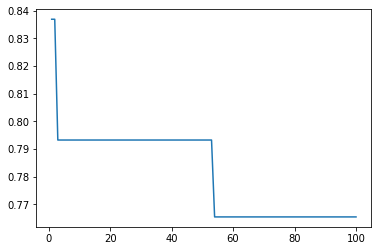

In [24]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss'].cummin()

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()

In [ ]:
df_i.to_csv("./data/saasbo.csv",index = None)